In [65]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

In [66]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [67]:
train_data = datasets.FashionMNIST(root='/data', train=True, download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(root='/data',train=False, download=True, transform=ToTensor())

In [68]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [69]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [70]:
# Each datapoint is a tuple of: 
# 1_ image tensor
# 2_ corresponding class

# Shape of each image = (1, 28, 28) which means that each image is 28 * 28 pixel image in grayp-scale channel

train_data[0][0].shape, train_data[0][1]

(torch.Size([1, 28, 28]), 9)

In [71]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

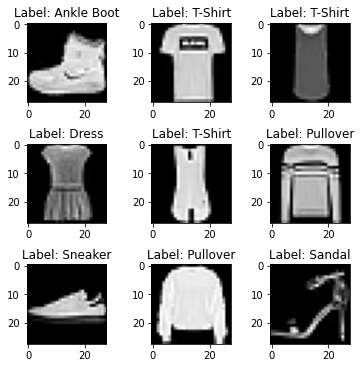

In [72]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(5, 5), constrained_layout = True)
n = 0
for i in range(3):
    for j in range(3):
        image = train_data[n][0].reshape(28, 28)
        label = labels_map[train_data[n][1]]
        axes[i][j].imshow(image, cmap='gray')
        axes[i][j].set_title(f'Label: {label}')
        n += 1

In [75]:
from torch.utils.data import DataLoader

# We can use each one of this two functions
func = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))

def one_hot_encoding(label):
    encoded_tensor = torch.zeros(10, dtype=torch.float32)
    encoded_tensor[label] = 1.0
    
    return encoded_tensor

train_data = datasets.FashionMNIST(root='/data', train=True, download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(root='/data',train=False, download=True, transform=ToTensor())

In [76]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

In [77]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU6(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [78]:
model = NeuralNetwork().to(device)

In [79]:
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU6()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)

In [80]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
logits

tensor([[0.0000, 0.0334, 0.0398, 0.0000, 0.0000, 0.0000, 0.0120, 0.0496, 0.0899,
         0.0000]], device='cuda:0', grad_fn=<ReluBackward0>)

In [81]:
pred_prob = nn.Softmax(dim=1)(logits)
pred_prob

tensor([[0.0977, 0.1011, 0.1017, 0.0977, 0.0977, 0.0977, 0.0989, 0.1027, 0.1069,
         0.0977]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [82]:
y_pred = pred_prob.argmax(dim=1)
y_pred

tensor([8], device='cuda:0')

In [83]:
# Model Parameters

In [84]:
model.named_parameters()
# It's a generator, so we can iterate over it and see what does each item is
# Each item is a tuple:
# 1_ Name
# 2_ Corresponding parameters

<generator object Module.named_parameters at 0x7f9b3bb2dba0>

In [85]:
for name, param in model.named_parameters():
    print(f"Name: {name}")
    print(f'Params shape: {param.shape}\n')


Name: linear_relu_stack.0.weight
Params shape: torch.Size([512, 784])

Name: linear_relu_stack.0.bias
Params shape: torch.Size([512])

Name: linear_relu_stack.2.weight
Params shape: torch.Size([512, 512])

Name: linear_relu_stack.2.bias
Params shape: torch.Size([512])

Name: linear_relu_stack.4.weight
Params shape: torch.Size([10, 512])

Name: linear_relu_stack.4.bias
Params shape: torch.Size([10])



In [96]:
learning_rate = 1e-3
batch_size = 64
epochs = 10

In [97]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
# Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [98]:
def training_loop(data_loader, model, loss_fn, optimizer):
    size = len(data_loader.dataset)
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch %100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(data_loader, model, loss_fn):
    size = len(data_loader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # Why using sum()? because we are performing this on mini-batches not a single item
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [99]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    training_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.819067  [    0/60000]
loss: 1.880959  [ 6400/60000]
loss: 1.616487  [12800/60000]
loss: 1.755870  [19200/60000]
loss: 1.740815  [25600/60000]
loss: 1.706523  [32000/60000]
loss: 1.806637  [38400/60000]
loss: 1.648026  [44800/60000]
loss: 1.870426  [51200/60000]
loss: 1.877596  [57600/60000]
Test Error: 
 Accuracy: 44.7%, Avg loss: 0.028293 

Epoch 2
-------------------------------
loss: 1.754521  [    0/60000]
loss: 1.915268  [ 6400/60000]
loss: 1.700444  [12800/60000]
loss: 1.756778  [19200/60000]
loss: 1.850529  [25600/60000]
loss: 1.739967  [32000/60000]
loss: 1.944309  [38400/60000]
loss: 1.878426  [44800/60000]
loss: 2.017154  [51200/60000]
loss: 1.709506  [57600/60000]
Test Error: 
 Accuracy: 46.3%, Avg loss: 0.027457 

Epoch 3
-------------------------------
loss: 1.698618  [    0/60000]
loss: 1.695363  [ 6400/60000]
loss: 1.636889  [12800/60000]
loss: 1.595433  [19200/60000]
loss: 1.705760  [25600/60000]
loss: 1.749767  [32000/600

In [100]:
torch.save(model.state_dict(), "/data/model.pth")

print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [103]:
import onnxruntime
import torch.onnx as onnx
import torchvision.models as models

In [104]:
saved_model = NeuralNetwork()
saved_model.load_state_dict(torch.load('/data/model.pth'))
saved_model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU6()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)

In [105]:
input_image = torch.zeros((1,28,28))
onnx_model = '/data/model.onnx'
onnx.export(saved_model, input_image, onnx_model)

In [106]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [107]:
x, y = test_data[0][0], test_data[0][1]

In [108]:
session = onnxruntime.InferenceSession(onnx_model, None)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

result = session.run([output_name], {input_name: x.numpy()})
predicted, actual = classes[result[0][0].argmax(0)], classes[y]
print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Sandal", Actual: "Ankle boot"
